In [1]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve

In [2]:
fruit_types = ['pera', 'banana', 'manzana', 'naranja']
audios = {fruit: [] for fruit in fruit_types}
root_dir = '../../dataset'

In [3]:
for dirname, _, filenames in os.walk(root_dir):
    fruit_type = os.path.basename(dirname)
    if fruit_type in fruit_types:
        audios[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])
processed = {fruit: [] for fruit in fruit_types}


In [4]:
for dirname, _, filenames in os.walk(root_dir):
    path = os.path.basename(dirname)
    if path == 'processed':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            processed[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])


In [5]:
FRAME_SIZE = 1024 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

In [6]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [7]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))


In [8]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)


In [9]:
def normalize(signal):
    peak = np.max(signal)
    signal/=peak
    return signal


In [10]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered

In [11]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

In [12]:
def wiener_filter(signal, noise = 0.9):
    filtered = wiener(signal, noise = noise)
    return filtered

In [13]:
def envelope(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)


In [14]:
def smooth_envelope(signal, sr, cutoff_frequency=50.0):
    return low_pass_filter(envelope(signal), sr, cutoff_frequency)


In [16]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()


In [ ]:
cutoff = 2000
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        #spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #BER  = band_energy_ratio(spec, split_frequency, sr)
        #BER /= np.max(BER)
        #feat = np.mean(BER)

        #centroidal = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #centroidal /= np.max(centroidal)
        #centroidal = np.mean(centroidal)
        #smoothed = rms(signal)
        #smoothed = smoothed.reshape(-1,)
        #rms_smoothed = np.mean(smoothed)/np.max(smoothed)
        #filtered = low_pass_filter(signal, sr, cutoff)
        #feat = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #max = np.max(zcr)
        #flux = spectral_flux(filtered)
        #max = np.max(flux)
        #flux /= max
        #flux = np.mean(flux)
        #roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.85)[0]
        #max = np.max(roll_off)
        #roll_off /= max
        #roll_off = np.mean(roll_off)
        #smoothed /= np.max(smoothed)
        #N = 1
        #feat = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = 5, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #feat = librosa.feature.delta(feat, order = 3)

        #frames = range(len(feat))
        #t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)

        #absolute = np.abs(feat)
        #feat /= np.max(absolute)
        #absolute /= np.max(absolute)
        #feat = np.abs(feat)
        #row = feat[N,:]
        #row = np.abs(row)

        #momentum = np.dot(t, absolute)
        #momentum/=np.sum(absolute)
        #means = np.mean(feat)

        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)



**Zero crossing rate**

- Media. Así de entrada puedo decir que el zero crossing rate anda bastante joya comparado con las medidas anteriores.
El ZCR funciona mejor con altos HOP_SIZE Y LENGTH_SIZE

C:\Users\Juan\AppData\Local\Temp\ipykernel_6956\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


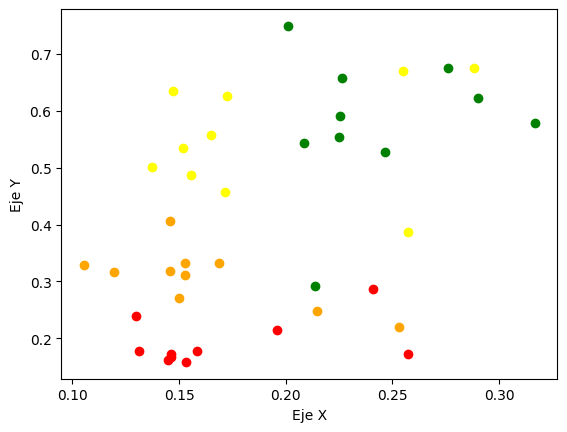

In [17]:
cutoff = 8500
cuton = 20
features = dict.fromkeys(fruit_types)
split_frequency = 200

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)
        signal = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        zcr /= np.max(np.abs(zcr))

        feat = np.mean(zcr)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- RMS. Mejor la media que el RMS

In [ ]:
cutoff = 8500
cuton = 20
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)
        
        signal = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        zcr /= np.max(np.abs(zcr))

        feat = np.sqrt(np.mean(zcr**2))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)


- Máximo. Fuaaaaa culiadooo. El ZCR separa joya las manzanas de las demas frutas. El máximo del zero crossing obviamente. Me gusta un poco mas sin filtro con el FRAME_SIZE a 2048 que en 512. Es mas, me gusta mas en 1024 que en 2048

C:\Users\Juan\AppData\Local\Temp\ipykernel_6956\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


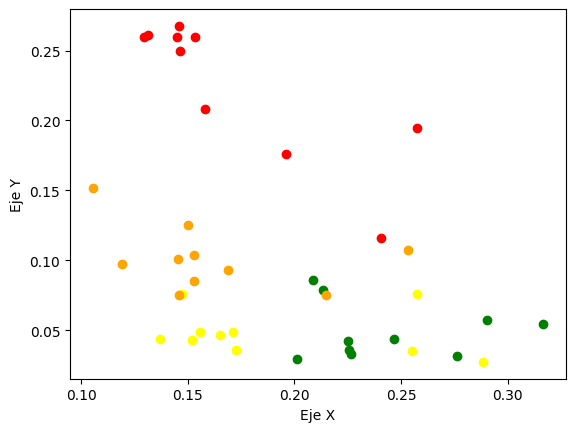

In [26]:
cutoff = 8500
cuton=20
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        signal = band_pass_filter(signal, sr, cuton, cutoff)

        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        feat = np.max(zcr)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)


- Con el mínimo

In [ ]:
cutoff = 8500
cuton=20
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        signal = band_pass_filter(signal, sr, cuton, cutoff)

        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        feat = np.min(np.abs(zcr))
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con la varianza. La varianza permite muy bien la separación de las manzanas

In [ ]:
cutoff = 8500
cuton=20
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        signal = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        feat = np.var(zcr)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con la desviación estándar. Nuevamente, se nota bastante la separación de las manzanas, pero las naranjas igual se ven en un cluster medio superpuesto con las bananas.

C:\Users\Juan\AppData\Local\Temp\ipykernel_5492\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


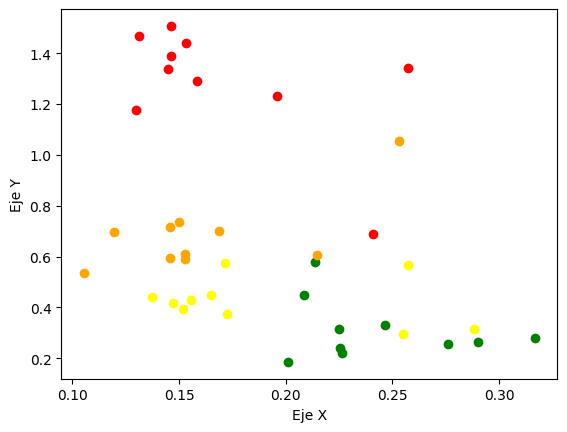

In [ ]:
cutoff = 8500
cuton=20
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)
        signal = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        feat = np.std(zcr)/np.mean(zcr)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con el momento sin la suma

In [ ]:
cutoff = 2000
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        frames = range(len(zcr))
        t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
        feat = np.dot(np.abs(zcr), t)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

- Con la suma

C:\Users\Juan\AppData\Local\Temp\ipykernel_5492\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


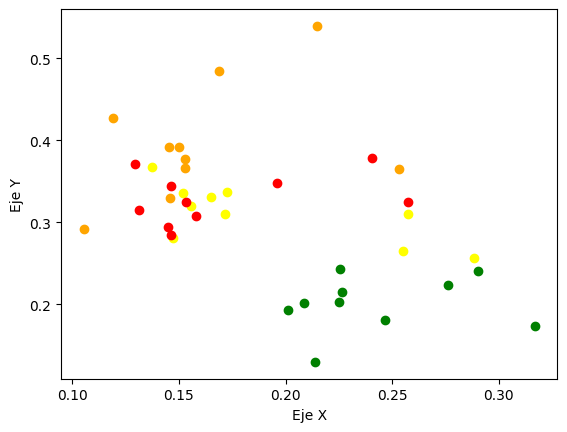

In [ ]:
cutoff = 8500
cuton=20
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        signal = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        frames = range(len(zcr))
        t = librosa.frames_to_time(frames, sr=sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
        feat = np.dot(zcr, t)/np.sum(zcr)
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

C:\Users\Juan\AppData\Local\Temp\ipykernel_6956\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


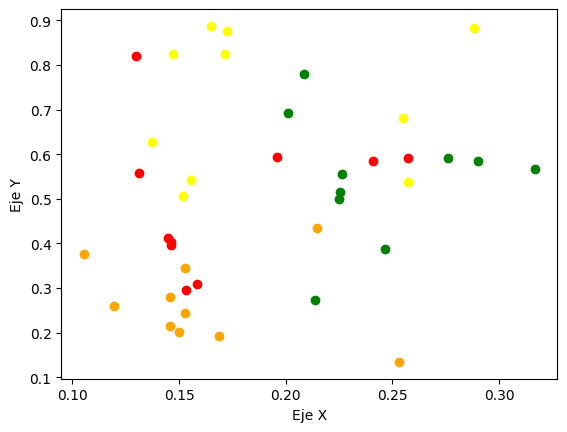

In [21]:
cutoff = 8500
cuton = 20
features = dict.fromkeys(fruit_types)
split_frequency = 200

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)
        signal = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        zcr /= np.max(np.abs(zcr))

        feat = np.mean(zcr[((len(zcr)*1)//2 - 5) : ((len(zcr)*1)//2 + 5)])
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

el máximo del zcr a los 2/3 separa las naranjas

C:\Users\Juan\AppData\Local\Temp\ipykernel_6956\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


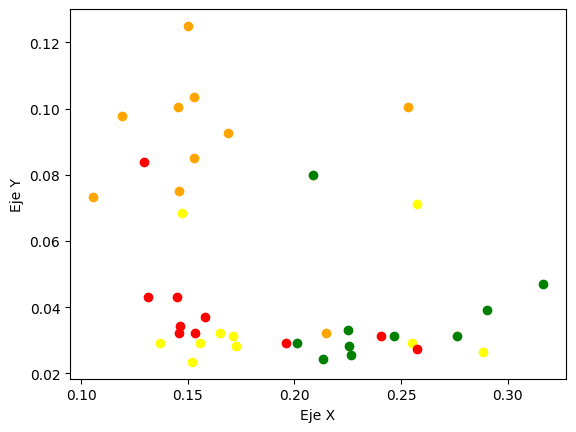

In [27]:
cutoff = 8500
cuton=20
features = dict.fromkeys(fruit_types)
split_frequency = 2000

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)

        signal = band_pass_filter(signal, sr, cuton, cutoff)

        zcr = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        feat = np.max(zcr[((len(zcr)*2)//3 - 5) : ((len(zcr)*2)//3 + 5)])
        
        feature = np.array([[audio_rms, feat]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)
